In [7]:
import numpy as np 
import numpy.ma as ma
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.cbook as cbook
import matplotlib.colors as colors

from tqdm import tqdm



import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy.io import fits
import glob
import pandas as pd
from astropy.table import Table



matplotlib.rcParams.update({'xtick.labelsize':18,
                            'ytick.labelsize':18,
                            'axes.titlesize':18,
                            'axes.labelsize':18,
                            'font.size':18,
                            'xtick.top':True,
                            'xtick.minor.visible':True,
                            'ytick.minor.visible':True,
                            'xtick.major.size':4,
                            'xtick.minor.size':2,
                            'ytick.major.size':4,
                            'ytick.minor.size':2,
                            'ytick.right':True,
                            'xtick.direction':'in',
                            'ytick.direction':'in',
                            'font.family':'serif'})

flags = ['BADPIX',
'CRPIX',
'SATPIX',
'UNFIXABLE',
'BADDARK',
'BADFLAT',
'BADERR',
'NOSKY',
'LITTROW_GHOST',
'PERSIST_HIGH',
'PERSIST_MED',
'PERSIST_LOW',
'SIG_SKYLINE',
'SIG_TELLURIC']


from TolColors import tol_cmap
cmap = tol_cmap('rainbow_PuRd')
cmap_diverge = tol_cmap('sunset')

## Data and function definition

In [8]:
tabfile = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStarLite-dr17-synspec_rev1.fits'
stars = Table.read(tabfile, hdu = 1)
select_bitmasked = np.where((np.bitwise_and(stars['ASPCAPFLAG'], 23) == 0) | 
                            (np.bitwise_and(stars['ASPCAPFLAG'], 19) == 0))[0]

stars = stars[select_bitmasked]

stars = stars[np.where((stars['TEFF_ERR'] < 600) & (stars['LOGG_ERR'] < 0.5) & (stars['M_H_ERR'] < 0.3))[0]]
# stars = stars[np.where(np.abs(stars['GLAT']) > 10)[0]]

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


In [9]:
x = fits.open(tabfile)


In [10]:
def getspecpaths(tab):
    specdir = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/{TELESCOPE}/{FIELD}/'
    specname = 'aspcapStar-dr17-{SOURCEID}.fits'
    telescope = np.array(tab['TELESCOPE'], dtype = str)
    field = np.array(tab['FIELD'], dtype = str)
    sourceid = np.array(tab['APOGEE_ID'], dtype = str)
    length = len(sourceid)
    path = tuple((specdir + specname).format(TELESCOPE = telescope[i], FIELD = field[i], SOURCEID = sourceid[i]) 
                 for i in range(length))
    return path

def getapstarpath(hdulist):
    specdir = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/redux/dr17/stars/{TELESCOPE}/{FIELD}/'
    telescope = str(hdulist[4].data['TELESCOPE'][0])
    field = str(hdulist[4].data['FIELD'][0])
    fname = str(hdulist[4].data['FILE'][0])
    path = ((specdir + fname).format(TELESCOPE = telescope, FIELD = field))
    return path
    

def getwavs(hdulist):
    header = hdulist[1].header
    CRVAL1 = header['CRVAL1']
    CDELT1 = header['CDELT1']
    wavs = np.power(10, CRVAL1 + CDELT1 * np.arange(len(hdulist[1].data)))
    return wavs 

def getspec(path):
    hdulist = fits.open(path)
    spectrum = hdulist[1].data
    model = hdulist[3].data
    wavs = getwavs(hdulist)
    return (spectrum, model, wavs)

## Binning visualizations

In [11]:
CA_fields = ['CA_161-06_btx', 'CA_161-06_btx', 'CA_162-11_btx', 'CA_163-05_btx', 'CA_163-08_btx',
             'CA_165-07_btx', 'CA_165-10_btx']

CA_inds = np.unique(np.concatenate([np.where(stars['FIELD'] == field)[0] for field in CA_fields]))
print('CA Cloud Stars:',  len(CA_inds))

CA_stars = stars[CA_inds]



CA Cloud Stars: 1116


/uufs/chpc.utah.edu/sys/srcdir/pylib/3.6.3/biokevlar/biokevlar-0.7/.eggs/matplotlib-3.3.2-py3.6-linux-x86_64.egg/matplotlib/colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


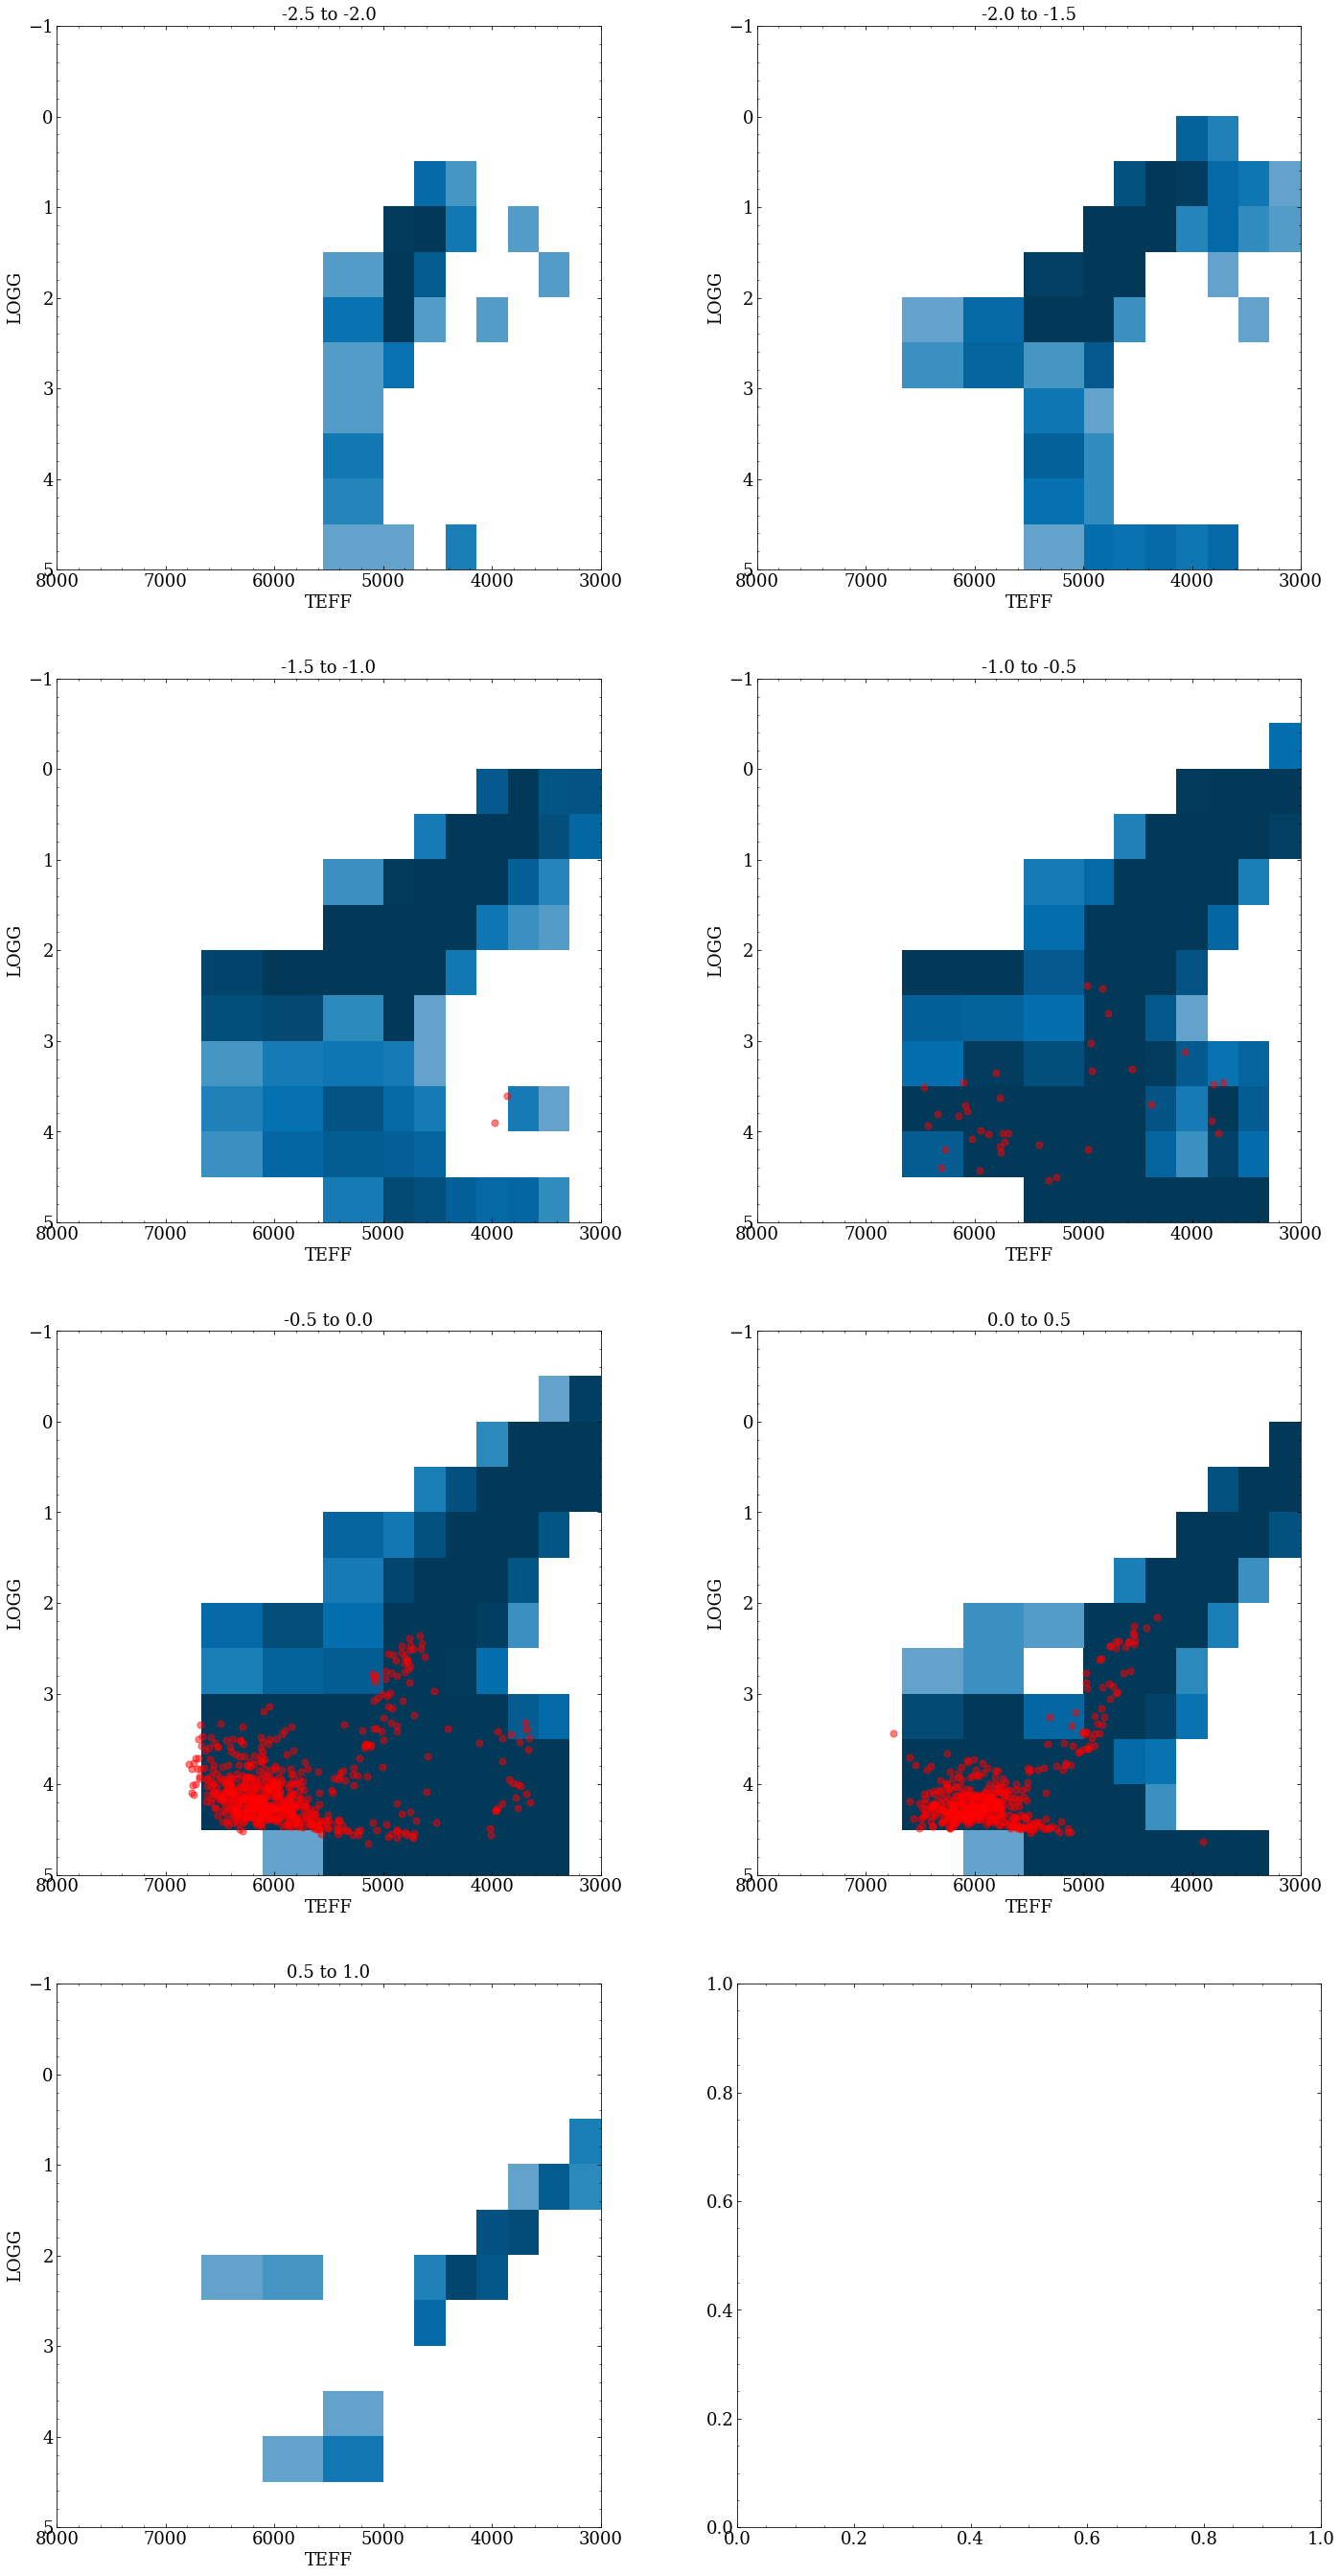

In [12]:
binmin, binmax = (2000, 8000)

fig, axs = plt.subplots(4,2, figsize = (24,48))

# teffbins = np.concatenate([np.arange(3000, 5000, 50), np.arange(5000,10000, 150), [10000]])
# loggbins = np.arange(-1, 5.2, 0.2)

teffbins = np.concatenate([np.arange(3000, 5000, 250), np.arange(5000,10000, 500), [10000]])
loggbins = np.arange(-1, 5.1, 0.5)    

def hr_hist_bins(ax, tab, fig = fig, teffbins = teffbins, loggbins = loggbins):
    binmin, binmax = (np.min(teffbins), np.max(teffbins))
    binmin_, binmax_ = (np.min(loggbins), np.max(loggbins))
    binsize = np.array([teffbins,loggbins])
    histrange = (teffbins, loggbins)
    hist = np.histogram2d(tab['TEFF'], tab['LOGG'], bins = binsize)[0]
    hist[np.where(hist < 4)] = np.nan
    norm = colors.LogNorm(vmin = 0.1, vmax = 100)
    
#     image = ax.imshow(hist.T[:, -1:0:-1], cmap = 'PuBu', extent = (binmax,binmin, binmax_,binmin_), vmin = 1, vmax = 20)#, norm = norm)#, vmin = 0, vmax= 50)#, norm = norm)
        
    
    bins1 = np.concatenate([np.arange(3000, 5000, 250), [5000]])
    bins2 = np.concatenate([np.arange(5000,10000, 500), [10000]])
    hist1 = np.histogram2d(tab['TEFF'], tab['LOGG'], bins = (bins1, loggbins))[0]
    hist1[np.where(hist1 < 4)] = np.nan
    norm = colors.LogNorm(vmin = 0.1, vmax = 100)


    image1 = ax.imshow(hist1.T[:, -1:0:-1], cmap = 'PuBu', extent = (5000,3000, 5,-1), norm = norm)#, vmin = 1, vmax = 20)#, norm = norm)#, vmin = 0, vmax= 50)#, norm = norm)
    hist2 = np.histogram2d(tab['TEFF'], tab['LOGG'], bins = (bins2, loggbins))[0]
    hist2[np.where(hist2 < 4)] = np.nan
    image2 = ax.imshow(hist2.T[:, -1:0:-1], cmap = 'PuBu', extent = (10000,5000, 5,-1), norm = norm)# vmin = 1, vmax = 20)#, norm = norm)#, vmin = 0, vmax= 50)#, norm = norm)

    
        
    ax.set_aspect((8000 - binmin) / 6)
#     fig.colorbar(image, ax = ax, label = 'Binned Stars',fraction=0.046)
    ax.set_xlim(8000, binmin)
    ax.set_ylim(binmax_, binmin_)
#     ax.set_xticks(np.arange(binmax, binmin, -1000))
    ax.set_xlabel('TEFF')
    ax.set_ylabel('LOGG')

def plot_hr(ax, tab, fig = fig):
    ax.scatter(tab['TEFF'], tab['LOGG'], color = 'r', s= 50, alpha = 0.5)

# fig.subplots_adjust(hspace=0.5)
m_h_bins = np.arange(-2.5, 1.1, .5)
for i in range(4):
    for j in range(2):
        if (i==3) & (j==1):
            break
        stars_restricted = stars[np.where((stars['M_H'] > m_h_bins[2*i+j]) & (stars['M_H'] < m_h_bins[2*i+j+1]))[0]]
#         hr_hist(axs[i, j], stars_restricted)
#         hr_hist_bins(axs[i,j], stars_restricted, teffbins = teffbins, loggbins = loggbins)
        axs[i,j].set_title(str(round(m_h_bins[2*i+j],1))+  ' to ' + str(round(m_h_bins[2*i+j+1],1)))
        
        
        CA_stars_restricted = CA_stars[np.where((CA_stars['M_H'] > m_h_bins[2*i+j]) & (CA_stars['M_H'] < m_h_bins[2*i+j+1]))[0]]
        hr_hist_bins(axs[i,j], stars_restricted)
        plot_hr(axs[i, j], CA_stars_restricted)
# hr_hist(axs[0,0], stars)
# hr_hist(axs[0,1], stars)
# hr_hist(axs[1,0], stars)
# hr_hist(axs[1,1], stars)
plt.show()

## Residuals
### Bitmasks

In [13]:
def create_mask(bitmask, flags = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], skipflags = []):
    # https://www.sdss.org/dr14/algorithms/bitmasks/#APOGEE_PIXMASK
    if type(flags) is not list:
        flags = [flags]
    if type(skipflags) is not list:
        skipflags = [skipflags]

    mask = np.zeros(bitmask.shape)
    for i in flags:
        if i not in skipflags:
            mask[np.bitwise_and(bitmask, 2**i) == 2**i] = 1
    return mask

def create_errmask(err, threshold = 2):
    med = np.nanmedian(err)
    mask = np.zeros(err.shape)
    mask[err > threshold * med] = 1
    return mask

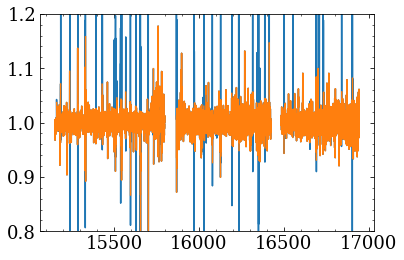

In [14]:
i = 1000
startest = stars[i:i+1]
hdulist1 = fits.open(getspecpaths(startest)[0])
bitmask = fits.open(getapstarpath(hdulist1))[3].data[0,:]
# mask = (np.bitwise_and(bitmask,11) == 1).astype(int) + (np.bitwise_and(bitmask, 13) == 1).astype(int) + (np.bitwise_and(bitmask, 14) == 1).astype(int)
# print(bitmask)
mask = create_mask(bitmask, skipflags = [10, 11]) #11 causes big gaps in the data - skipping medium and low persistence


fig = plt.figure()
ax = plt.subplot()
def quickplot(hdulist, ax, mask = None, lims = None):
    wavs = getwavs(hdulist)
    spec = hdulist[1].data
    mod = hdulist[3].data
    if mask is not None:
        wavs = ma.array(wavs, mask = mask)
        spec = ma.array(spec,mask = mask)
        mod = ma.array(mod, mask = mask)
    with np.errstate(divide = 'ignore', invalid = 'ignore'):
        res = np.divide(spec,mod)
    
    ax.plot(wavs, res)
    ax.set_ylim(.8, 1.2)
    
quickplot(hdulist1, ax)# mask = bitmask)
quickplot(hdulist1, ax, mask = mask)
plt.show()

0.010387860238552094


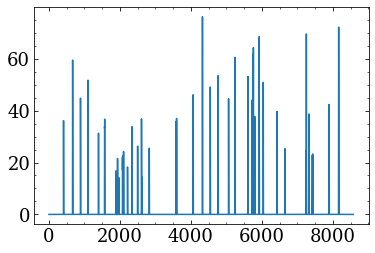

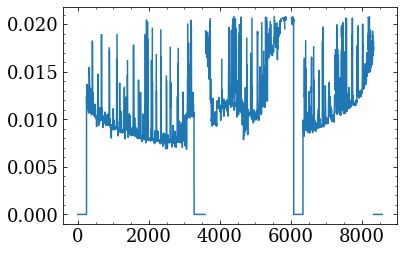

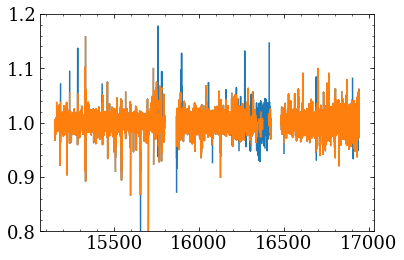

In [15]:
plt.plot(hdulist1[2].data)
print(np.median(hdulist1[2].data))
plt.show()

dat = hdulist1[2].data
m = np.zeros(len(dat))
m[np.where(dat > 2 * np.nanmedian(dat))[0]] = 1
dat_m = ma.array(dat, mask = m)
plt.plot(dat_m)
plt.show()

fig = plt.figure()
ax = plt.subplot()
mask_errs = create_errmask(hdulist1[2].data, threshold = 2)
mask_ = mask + mask_errs
# quickplot(hdulist1, ax)
quickplot(hdulist1, ax, mask = mask)
quickplot(hdulist1, ax, mask = mask_)
plt.show()

In [ ]:
# teff_bins = np.concatenate([np.arange(3000, 5000, 50), np.arange(5000,10000, 150), [10000]])
# logg_bins = np.arange(-1, 5.2, 0.2)
# m_h_bins = np.concatenate([np.arange(-2.3, -1.1, 0.3), np.arange(-1.1, 0.5, 0.2), [0.5]])

teff_bins = np.concatenate([np.arange(3000, 5000, 250), np.arange(5000,10000, 500), [10000]])
logg_bins = np.arange(-1, 5.1, 0.5)
m_h_bins = np.concatenate([np.arange(-2.5, 1.0, .3), [1]])

CA_stars['RES_STD'] = np.empty(len(CA_stars))
CA_stars['BINNED'] = np.zeros(len(CA_stars))

# teff_bins = np.append(np.arange(3000, 10000, 2000), np.arange(10000, 22000, 2000))
# print(len(teff_bins))
# logg_bins = np.arange(0, 5, 0.5)
# print(len(logg_bins))
# m_h_bins = np.arange(-2.5, 1, 0.5)
# print(len(m_h_bins))

 16%|█▌        | 3/19 [00:01<00:08,  1.87it/s]

bin (3750, 4000) (4.0, 4.5) (-0.40000000000000124, -0.10000000000000142) stars in bin 6


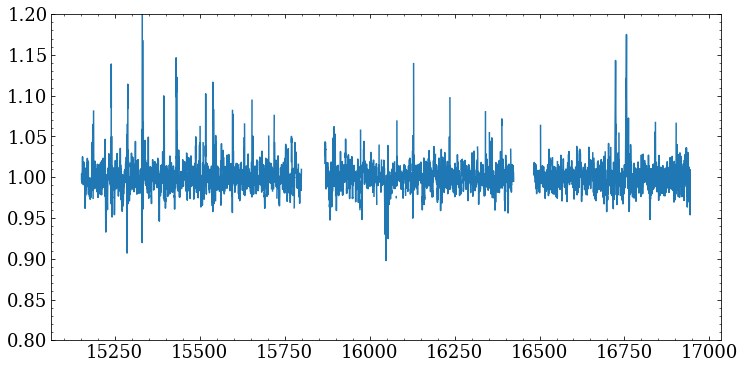

 32%|███▏      | 6/19 [00:03<00:08,  1.58it/s]

bin (4500, 4750) (2.0, 2.5) (-0.10000000000000142, 0.1999999999999984) stars in bin 7


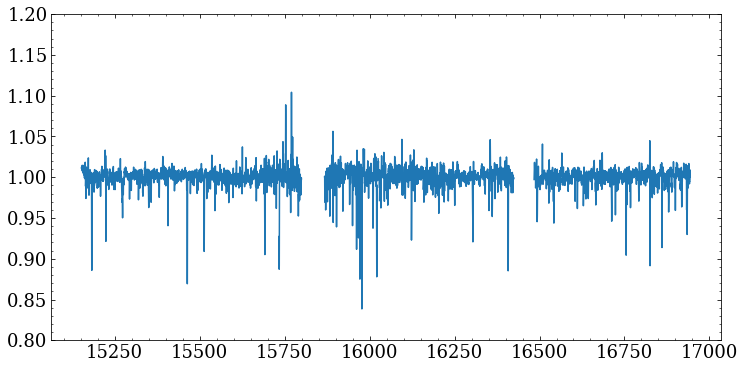

 37%|███▋      | 7/19 [00:05<00:08,  1.39it/s]

bin (4750, 5000) (2.5, 3.0) (-0.40000000000000124, -0.10000000000000142) stars in bin 10


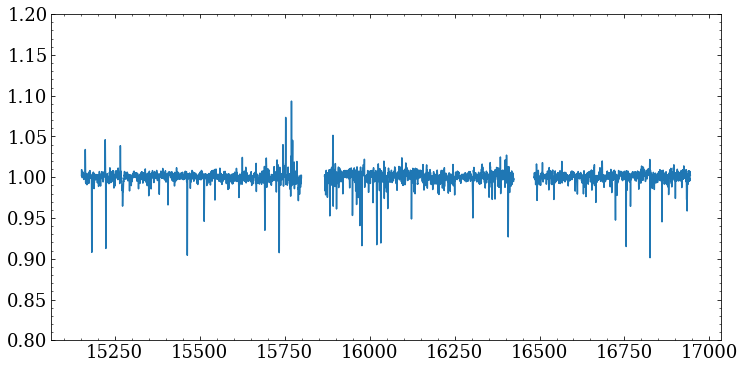

bin (4750, 5000) (2.5, 3.0) (-0.10000000000000142, 0.1999999999999984) stars in bin 12


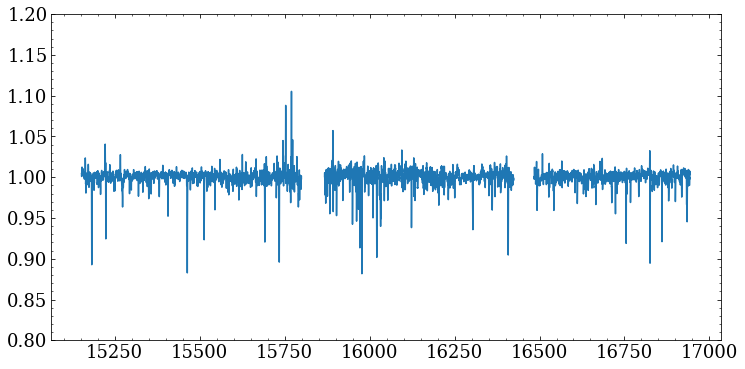

bin (4750, 5000) (3.0, 3.5) (-0.10000000000000142, 0.1999999999999984) stars in bin 9


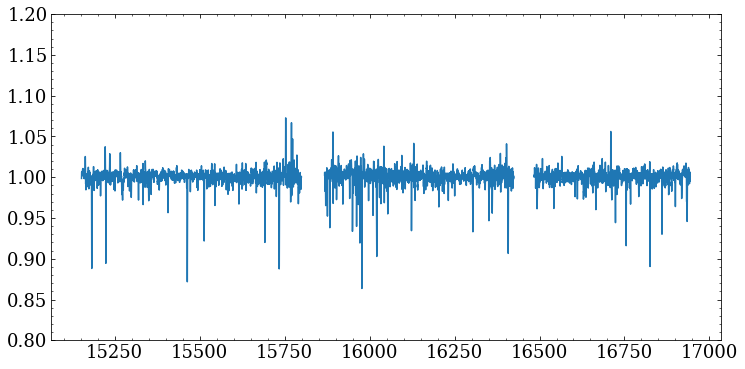

bin (4750, 5000) (4.5, 5.0) (-0.40000000000000124, -0.10000000000000142) stars in bin 7


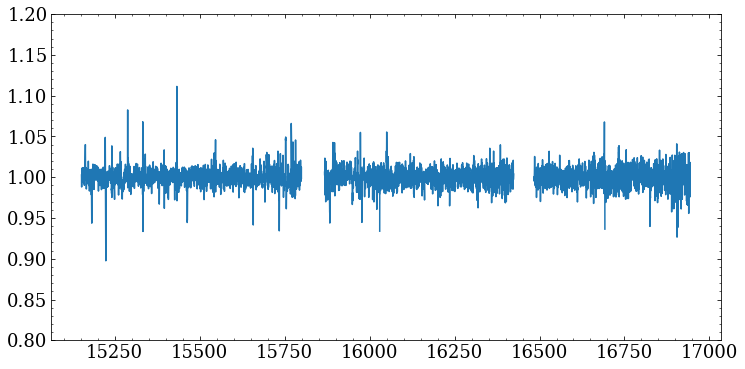

 42%|████▏     | 8/19 [00:08<00:12,  1.09s/it]

bin (5000, 5500) (3.0, 3.5) (-0.10000000000000142, 0.1999999999999984) stars in bin 8


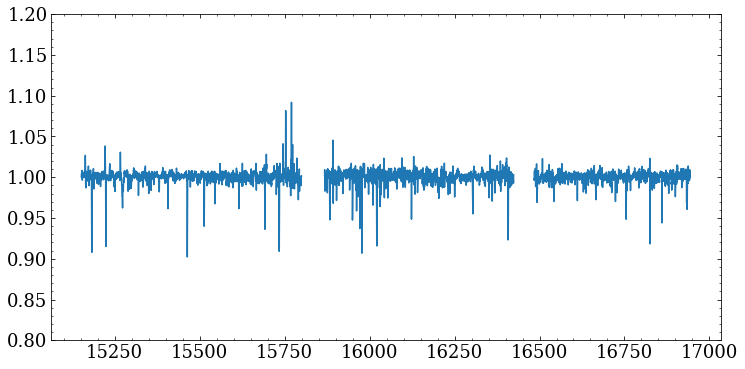

bin (5000, 5500) (3.5, 4.0) (-0.40000000000000124, -0.10000000000000142) stars in bin 11


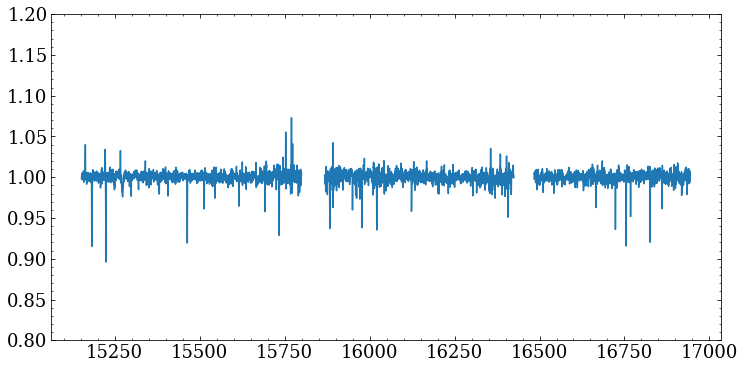

bin (5000, 5500) (3.5, 4.0) (-0.10000000000000142, 0.1999999999999984) stars in bin 16


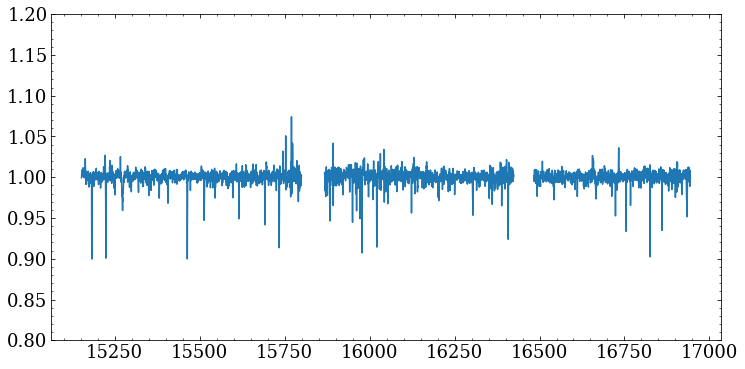

bin (5000, 5500) (4.0, 4.5) (-0.40000000000000124, -0.10000000000000142) stars in bin 8


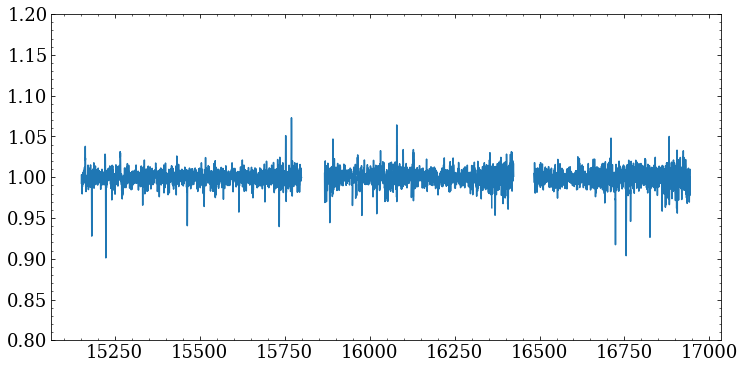

bin (5000, 5500) (4.0, 4.5) (-0.10000000000000142, 0.1999999999999984) stars in bin 10


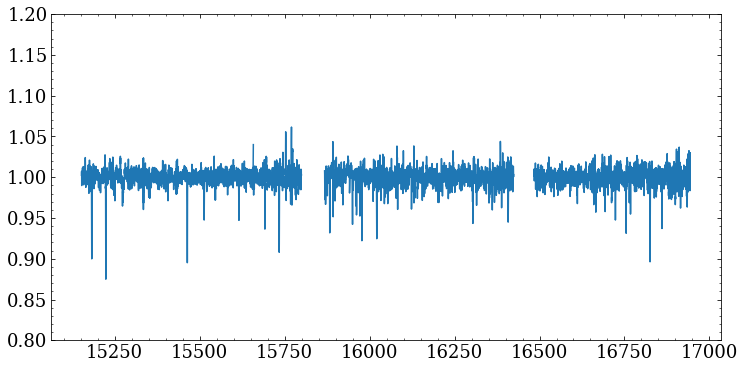

bin (5000, 5500) (4.0, 4.5) (0.1999999999999984, 0.4999999999999982) stars in bin 9


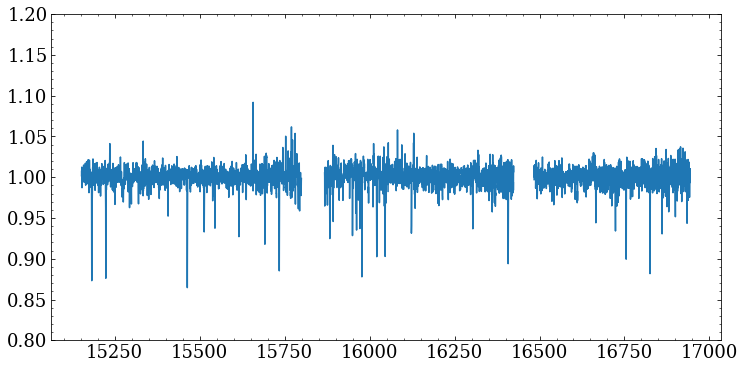

bin (5000, 5500) (4.5, 5.0) (-0.10000000000000142, 0.1999999999999984) stars in bin 11


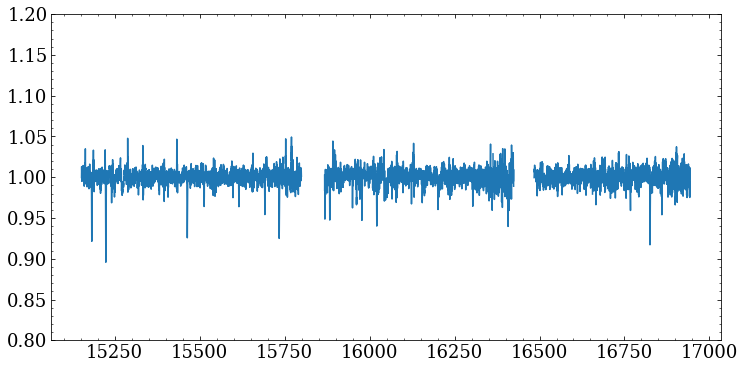

 47%|████▋     | 9/19 [00:15<00:17,  1.70s/it]

bin (5500, 6000) (3.5, 4.0) (-0.40000000000000124, -0.10000000000000142) stars in bin 15


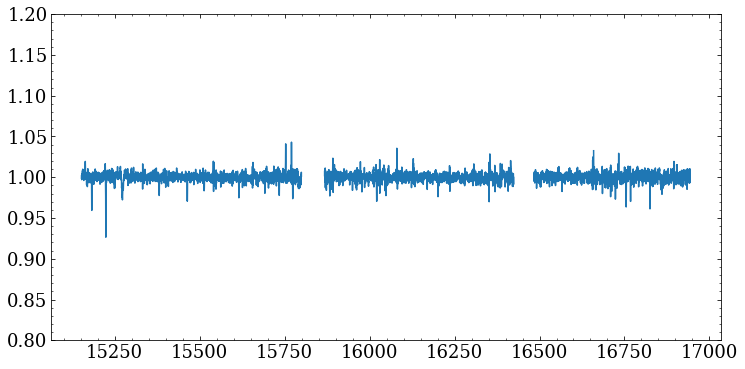

bin (5500, 6000) (3.5, 4.0) (-0.10000000000000142, 0.1999999999999984) stars in bin 17


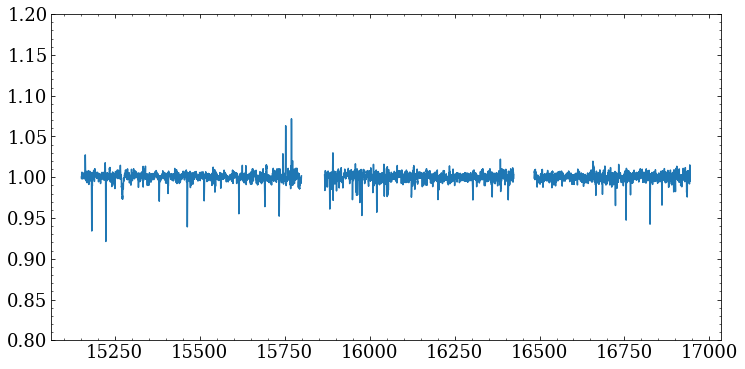

bin (5500, 6000) (4.0, 4.5) (-0.7000000000000011, -0.40000000000000124) stars in bin 15


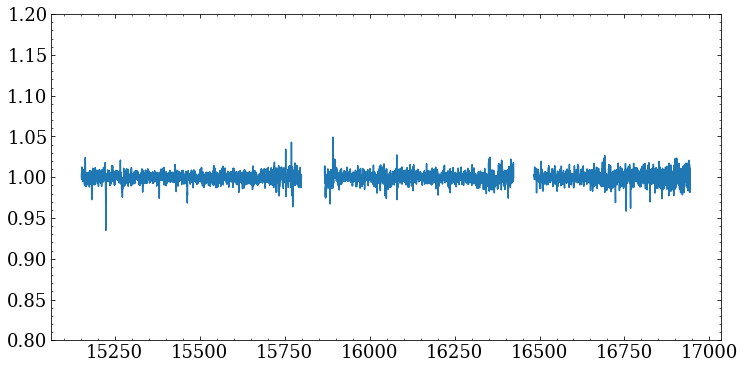

bin (5500, 6000) (4.0, 4.5) (-0.40000000000000124, -0.10000000000000142) stars in bin 64


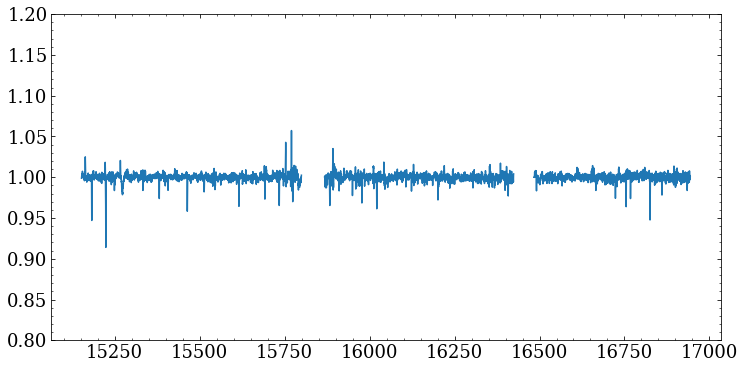

bin (5500, 6000) (4.0, 4.5) (-0.10000000000000142, 0.1999999999999984) stars in bin 193


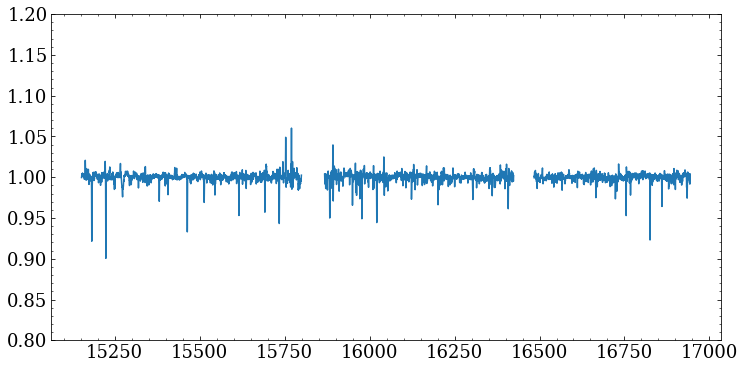

bin (5500, 6000) (4.0, 4.5) (0.1999999999999984, 0.4999999999999982) stars in bin 29


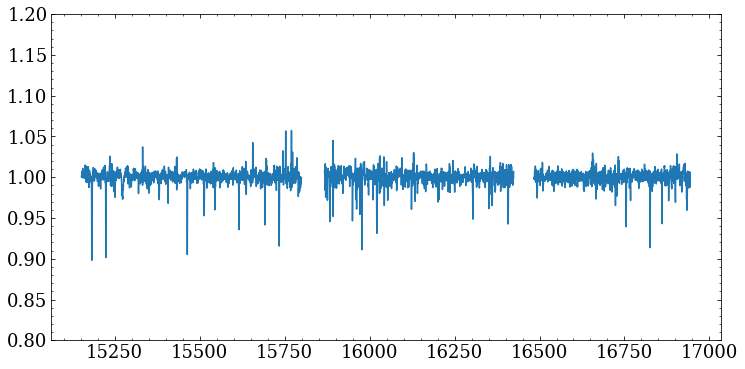

 53%|█████▎    | 10/19 [00:35<00:31,  3.52s/it]

bin (6000, 6500) (3.5, 4.0) (-0.7000000000000011, -0.40000000000000124) stars in bin 12


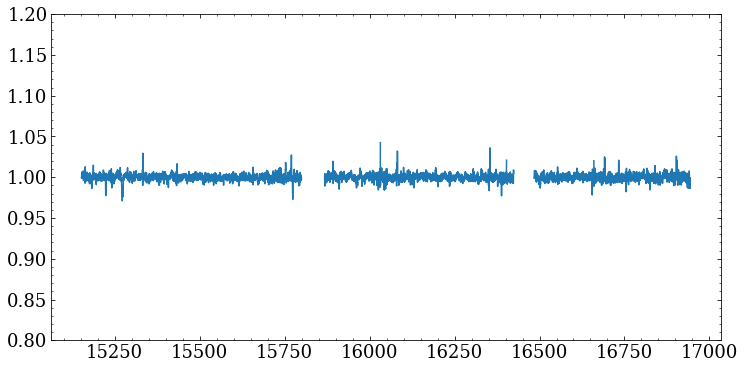

bin (6000, 6500) (3.5, 4.0) (-0.40000000000000124, -0.10000000000000142) stars in bin 47


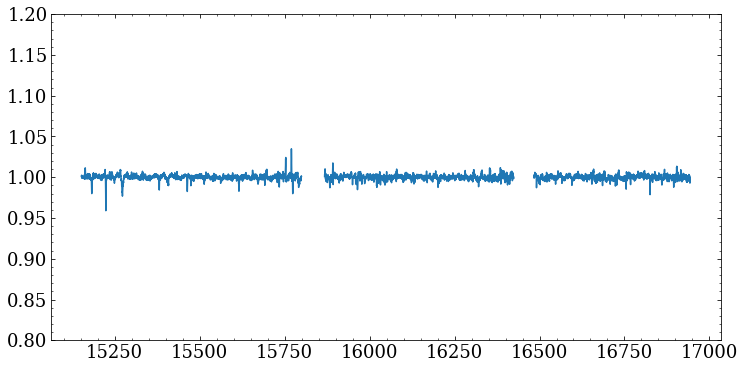

bin (6000, 6500) (3.5, 4.0) (-0.10000000000000142, 0.1999999999999984) stars in bin 29


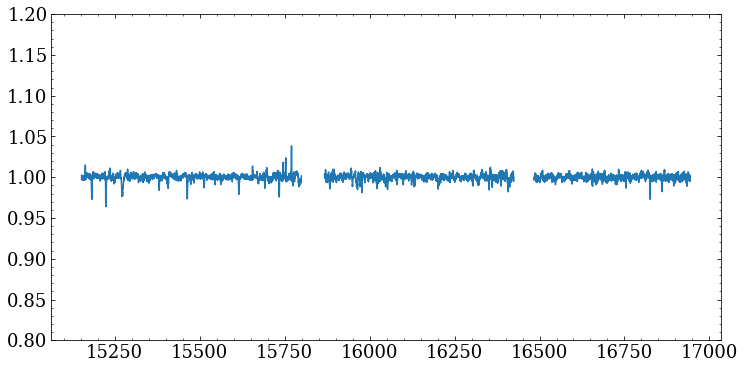

bin (6000, 6500) (4.0, 4.5) (-0.7000000000000011, -0.40000000000000124) stars in bin 11


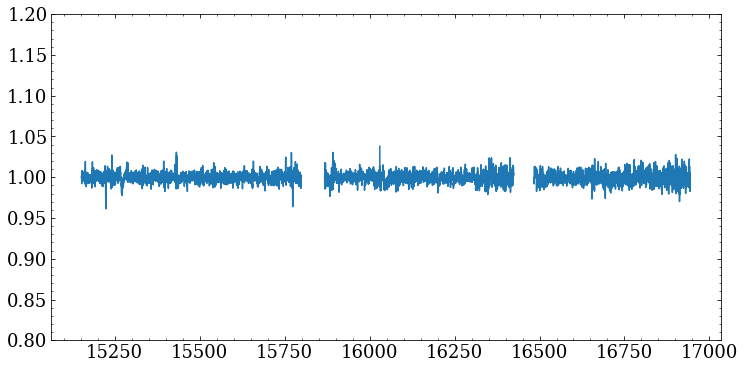

bin (6000, 6500) (4.0, 4.5) (-0.40000000000000124, -0.10000000000000142) stars in bin 128


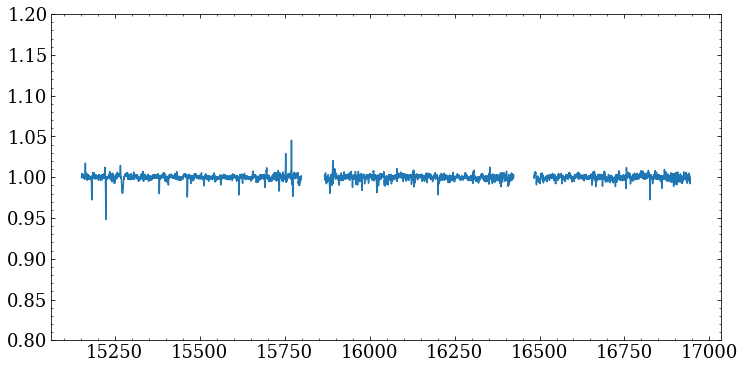

bin (6000, 6500) (4.0, 4.5) (-0.10000000000000142, 0.1999999999999984) stars in bin 217


In [ ]:
def get_selected_stars(tab, teff_bin, logg_bin, m_h_bin, return_indices = False):
    with np.errstate(divide='ignore', invalid = 'ignore'):
        indices = np.where((tab['TEFF'] > teff_bin[0]) & (tab['TEFF'] < teff_bin[1]) & 
                            (tab['LOGG'] > logg_bin[0]) & (tab['LOGG'] < logg_bin[1]) & 
                            (tab['M_H'] > m_h_bin[0]) & (tab['M_H'] < m_h_bin[1]))[0]
    if return_indices:
        return indices
    else:
        return tab[indices]

for i in tqdm(range(len(teff_bins)-1), total = len(teff_bins)):
    for j in range(len(logg_bins)-1):
        for k in range(len(m_h_bins)-1):
            teff_bin = (teff_bins[i], teff_bins[i+1])
            logg_bin = (logg_bins[j], logg_bins[j+1])
            m_h_bin = (m_h_bins[k], m_h_bins[k+1])
            
            selected_i = get_selected_stars(CA_stars, teff_bin, logg_bin, m_h_bin, return_indices = True)
            select = CA_stars[selected_i]
                
            
            
            stars_names = getspecpaths(select)
    
            nstars = len(stars_names)
            if nstars > 5:
                print('bin', teff_bin, logg_bin, m_h_bin, 'stars in bin', len(stars_names))
                CA_stars['BINNED'][selected_i] = nstars
                
                hdus = tuple(fits.open(name) for name in stars_names)
                headers = tuple(hdu[1].header for hdu in hdus)
                CRVAL1 = headers[0]['CRVAL1']
                CDELT1 = headers[0]['CDELT1']
                
                apStar = tuple(getapstarpath(hdu_) for hdu_ in hdus)
                bitmask = np.array(tuple(fits.open(name)[3].data[0,:] for name in apStar))
                
                errors = np.array(tuple(hdu[2].data for hdu in hdus))
                
                mask = create_mask(bitmask, skipflags = [10,11]).astype(int)
                mask = mask + create_errmask(errors, threshold = 2).astype(int)
                
                
                spectra = ma.array(tuple(hdu[1].data for hdu in hdus), mask = mask)
                models = ma.array(tuple(hdu[3].data for hdu in hdus), mask = mask)
#                 errors = ma.array(tuple(hdu[2].data for hdu in hdus), )
            
                
                
                with np.errstate(divide='ignore', invalid = 'ignore'):
                    residuals = spectra / models
                    
                residuals_median, resstd = (ma.median(residuals, axis = 0), ma.std(residuals, ddof = 1, axis = 0))
                
                CA_stars['RES_STD'][selected_i] = ma.mean(resstd)
                
                wavs = np.power(10, CRVAL1 + CDELT1 * np.arange(len(residuals_median)))

                fig = plt.figure(figsize = (12,6))
                ax = plt.subplot()
                ax.plot(wavs, residuals_median)
#                 ax.set_xlim(15250, 15500)
                ax.set_ylim(.8, 1.2)
                plt.show()
            
                header = fits.Header()
                header['NBIN'] = nstars
                header['CRVAL1'] = CRVAL1
                header['CDELT1'] = CDELT1
                header['COMMENT'] = 'BINBORDERS: TEFF ' + str(teff_bin) + ' LOGG ' + str(logg_bin)  + ' M_H ' + str(m_h_bin)
                primaryhdu = fits.PrimaryHDU(header = header)
                residualhdu = fits.ImageHDU(data = residuals_median.filled(np.NaN))
                errhdu = fits.ImageHDU(data = resstd.filled(np.NaN))
                
                hdul = fits.HDUList([primaryhdu, residualhdu, errhdu])
                fname = 'residual_CA_' + str(i) + '_' + str(j) + '_'+ str(k) + '.fits'
                
#                 hdul.writeto('StellarResidualsSpring2022/ResidualsFiles/CACLOUD/' + fname, overwrite = True)
                
                
            
            



In [ ]:
np.array([[12,13],[13,24]])[np.bitwise_and([[12,13],[13,24]], 12) == 12]

 16%|█▌        | 3/19 [00:01<00:08,  1.80it/s]

bin (3750, 4000) (4.0, 4.5) (-0.40000000000000124, -0.10000000000000142) stars in bin 6


/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


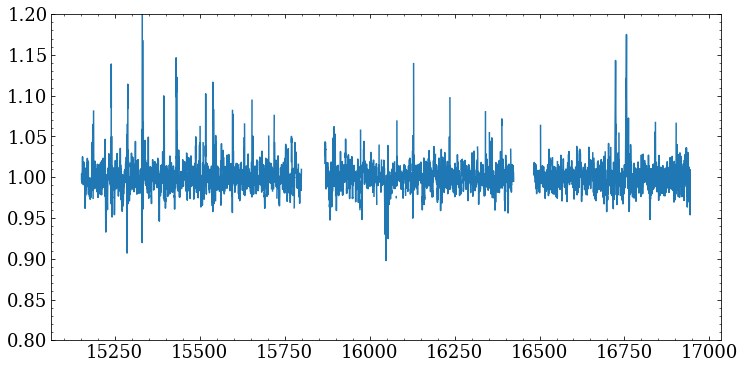

 32%|███▏      | 6/19 [00:04<00:08,  1.50it/s]

bin (4500, 4750) (2.0, 2.5) (-0.10000000000000142, 0.1999999999999984) stars in bin 7


/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


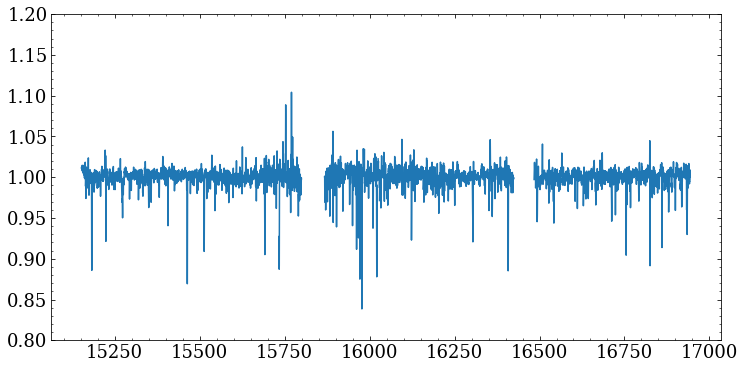

 37%|███▋      | 7/19 [00:05<00:08,  1.35it/s]

bin (4750, 5000) (2.5, 3.0) (-0.40000000000000124, -0.10000000000000142) stars in bin 10


/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


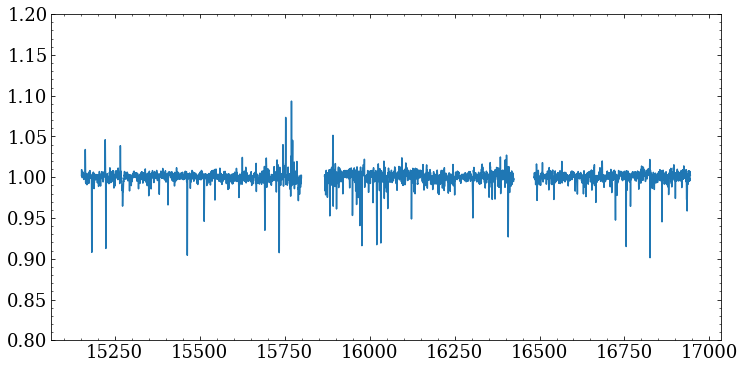

bin (4750, 5000) (2.5, 3.0) (-0.10000000000000142, 0.1999999999999984) stars in bin 12


/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


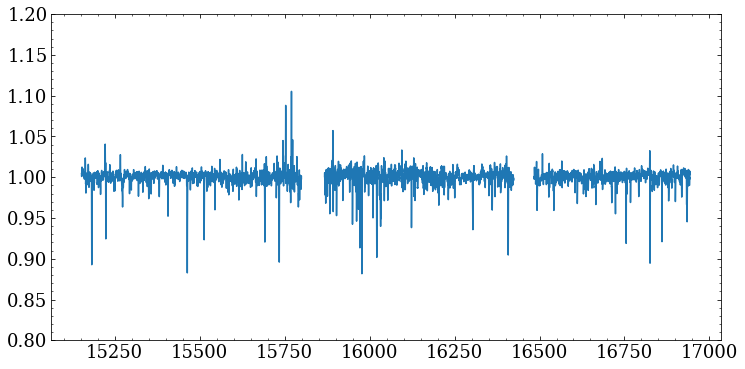

bin (4750, 5000) (3.0, 3.5) (-0.10000000000000142, 0.1999999999999984) stars in bin 9


/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


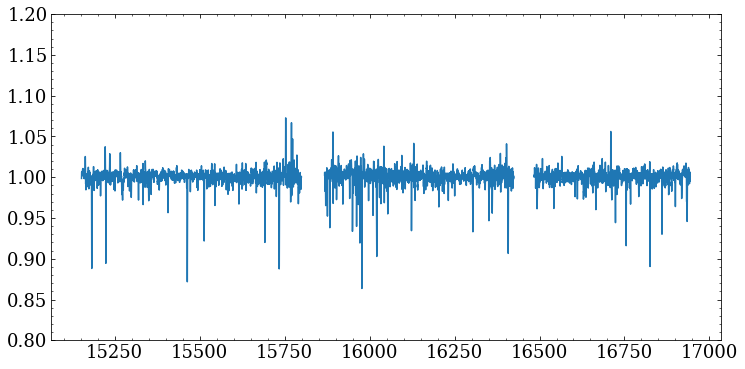

bin (4750, 5000) (4.5, 5.0) (-0.40000000000000124, -0.10000000000000142) stars in bin 7


/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


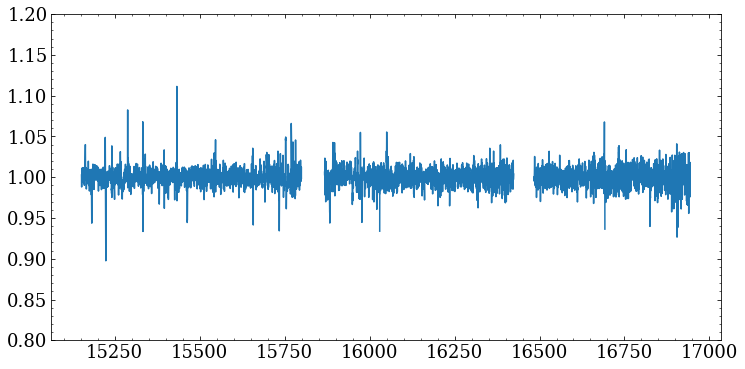

 42%|████▏     | 8/19 [00:08<00:12,  1.12s/it]

bin (5000, 5500) (3.0, 3.5) (-0.10000000000000142, 0.1999999999999984) stars in bin 8


/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


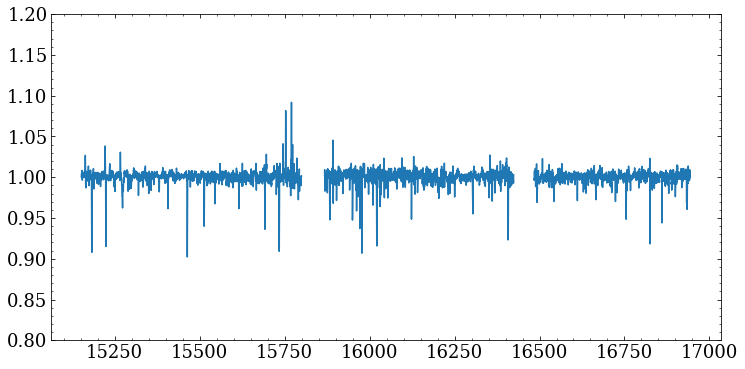

bin (5000, 5500) (3.5, 4.0) (-0.40000000000000124, -0.10000000000000142) stars in bin 11


/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


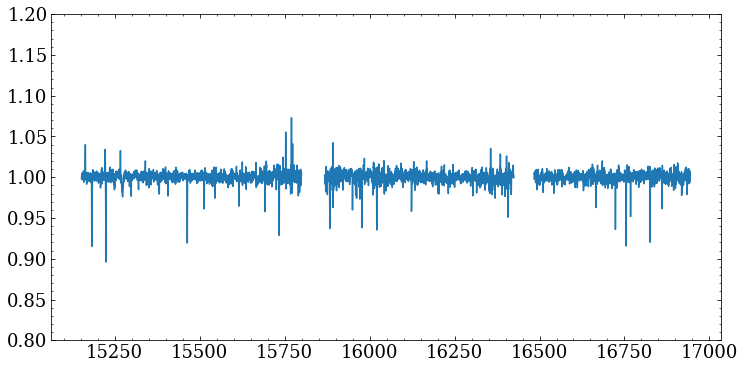

bin (5000, 5500) (3.5, 4.0) (-0.10000000000000142, 0.1999999999999984) stars in bin 16


/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


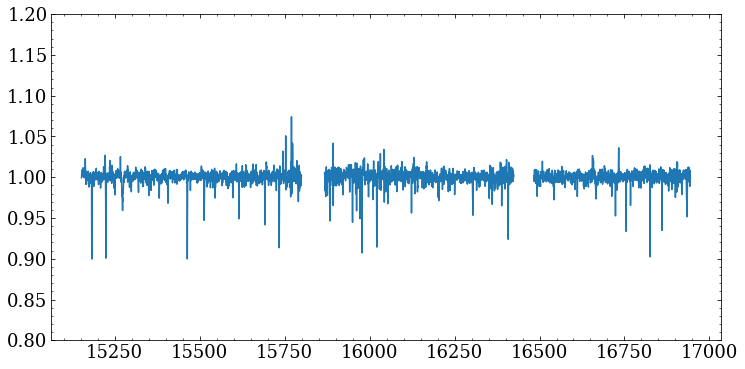

bin (5000, 5500) (4.0, 4.5) (-0.40000000000000124, -0.10000000000000142) stars in bin 8


/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


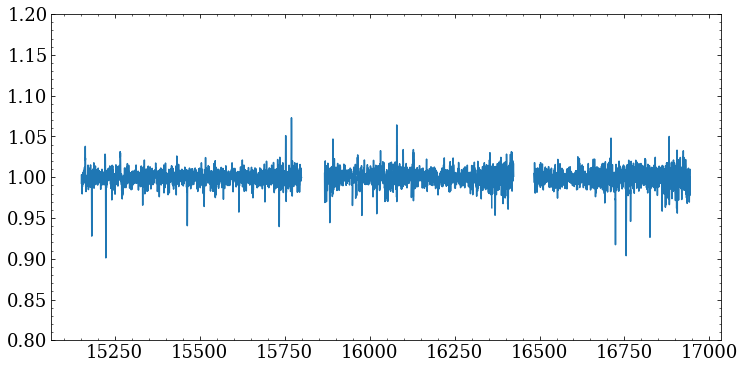

bin (5000, 5500) (4.0, 4.5) (-0.10000000000000142, 0.1999999999999984) stars in bin 10


/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


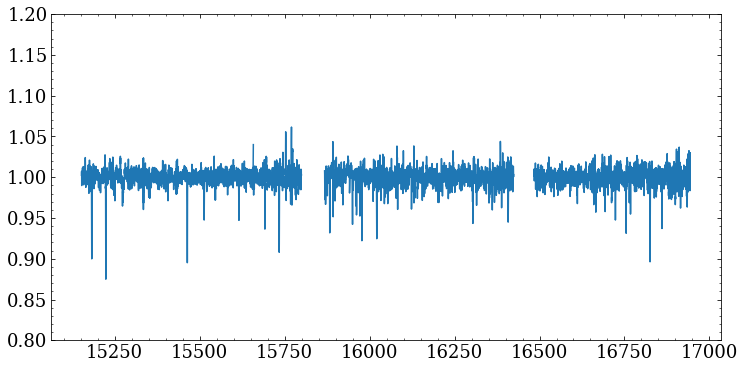

bin (5000, 5500) (4.0, 4.5) (0.1999999999999984, 0.4999999999999982) stars in bin 9


/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


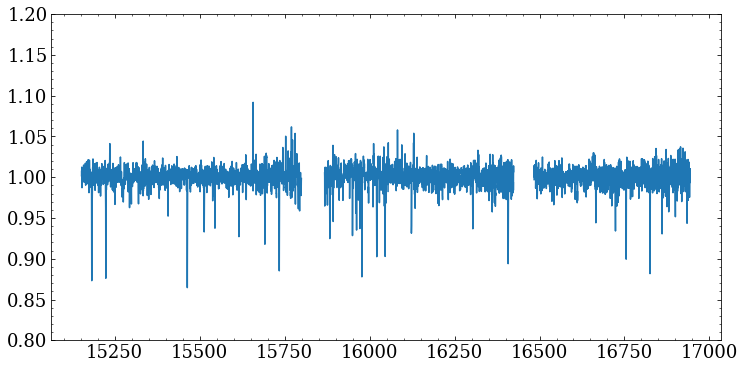

bin (5000, 5500) (4.5, 5.0) (-0.10000000000000142, 0.1999999999999984) stars in bin 11


/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


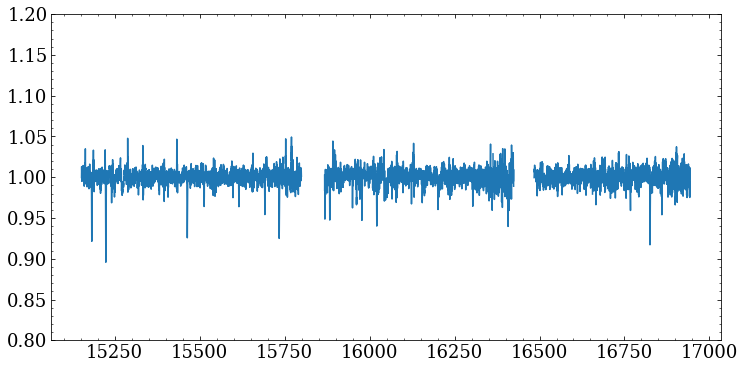

 47%|████▋     | 9/19 [00:15<00:17,  1.73s/it]

bin (5500, 6000) (3.5, 4.0) (-0.40000000000000124, -0.10000000000000142) stars in bin 15


/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


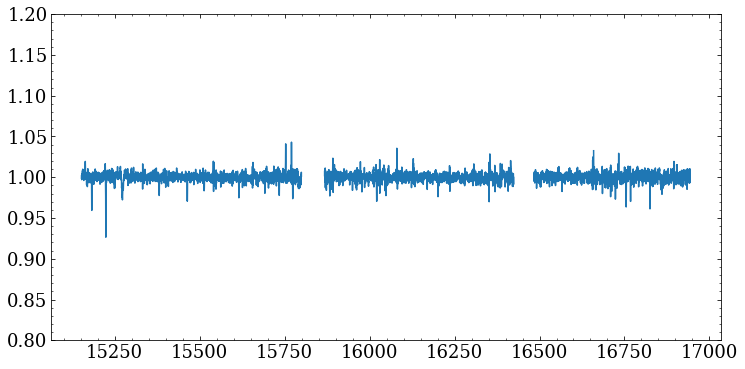

bin (5500, 6000) (3.5, 4.0) (-0.10000000000000142, 0.1999999999999984) stars in bin 17


/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


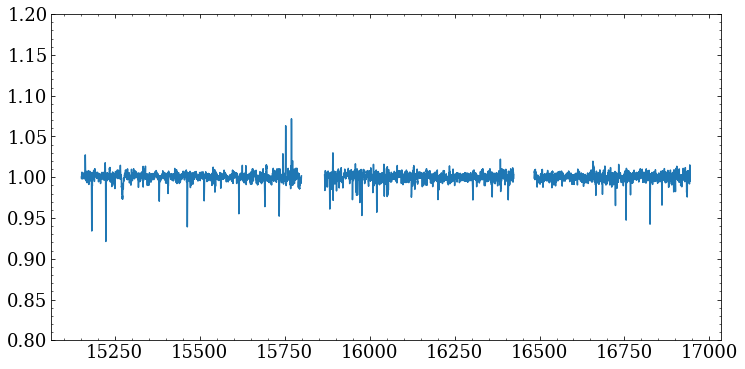

bin (5500, 6000) (4.0, 4.5) (-0.7000000000000011, -0.40000000000000124) stars in bin 15


/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


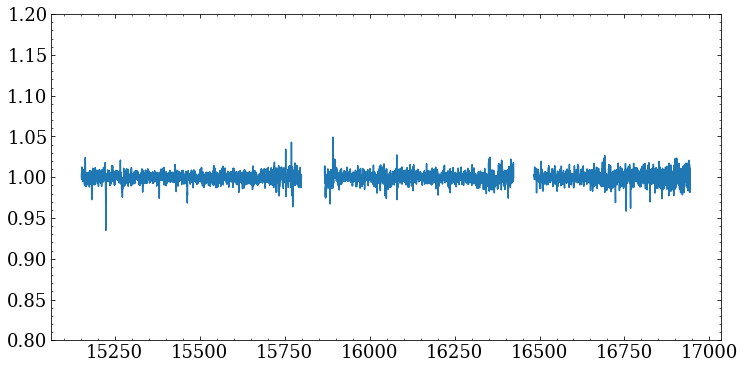

bin (5500, 6000) (4.0, 4.5) (-0.40000000000000124, -0.10000000000000142) stars in bin 64


/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


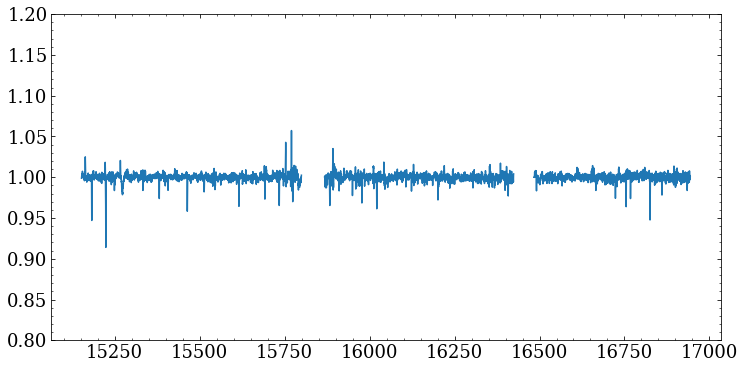

bin (5500, 6000) (4.0, 4.5) (-0.10000000000000142, 0.1999999999999984) stars in bin 193


/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


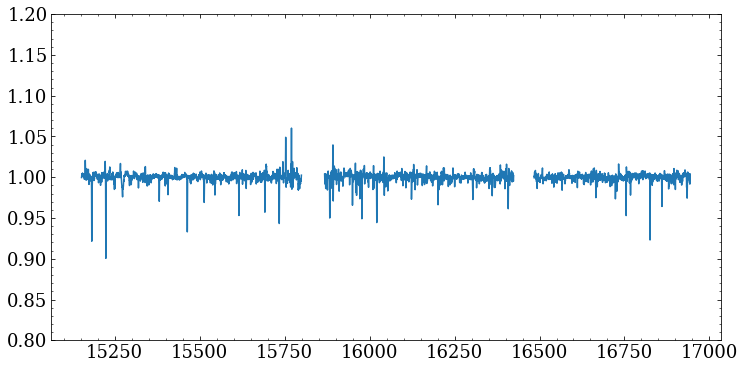

bin (5500, 6000) (4.0, 4.5) (0.1999999999999984, 0.4999999999999982) stars in bin 29


/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


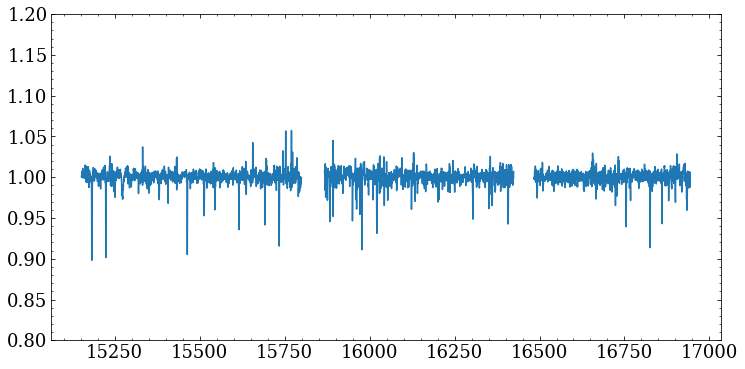

 53%|█████▎    | 10/19 [00:35<00:31,  3.53s/it]

bin (6000, 6500) (3.5, 4.0) (-0.7000000000000011, -0.40000000000000124) stars in bin 12


/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


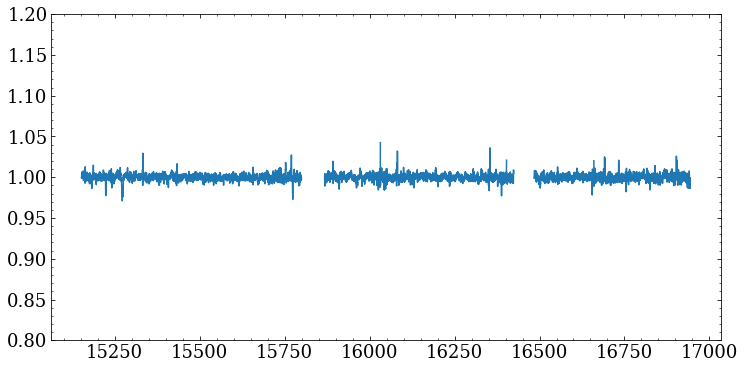

bin (6000, 6500) (3.5, 4.0) (-0.40000000000000124, -0.10000000000000142) stars in bin 47


/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


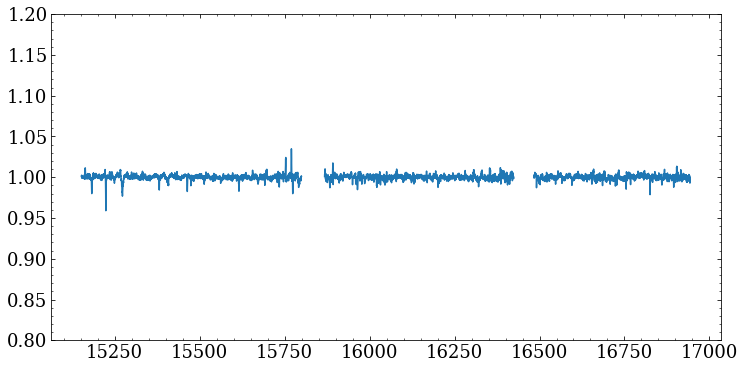

bin (6000, 6500) (3.5, 4.0) (-0.10000000000000142, 0.1999999999999984) stars in bin 29


/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


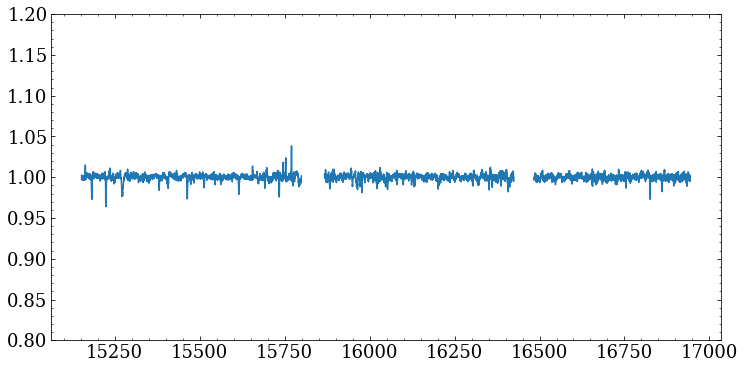

bin (6000, 6500) (4.0, 4.5) (-0.7000000000000011, -0.40000000000000124) stars in bin 11


/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


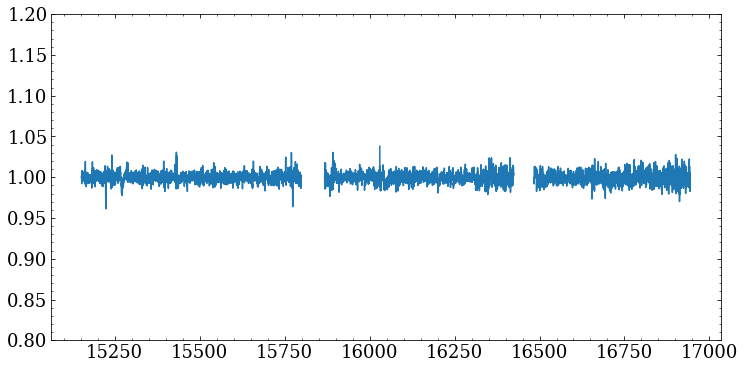

bin (6000, 6500) (4.0, 4.5) (-0.40000000000000124, -0.10000000000000142) stars in bin 128


/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


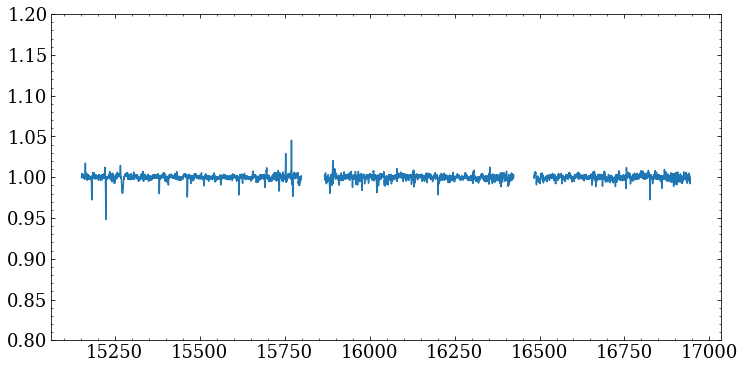

bin (6000, 6500) (4.0, 4.5) (-0.10000000000000142, 0.1999999999999984) stars in bin 217


/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


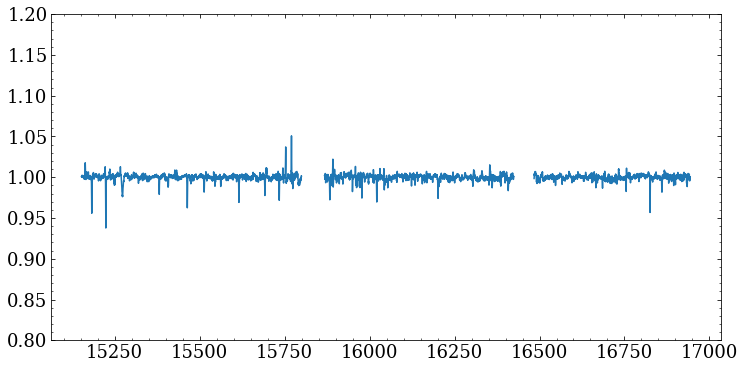

bin (6000, 6500) (4.0, 4.5) (0.1999999999999984, 0.4999999999999982) stars in bin 22


/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


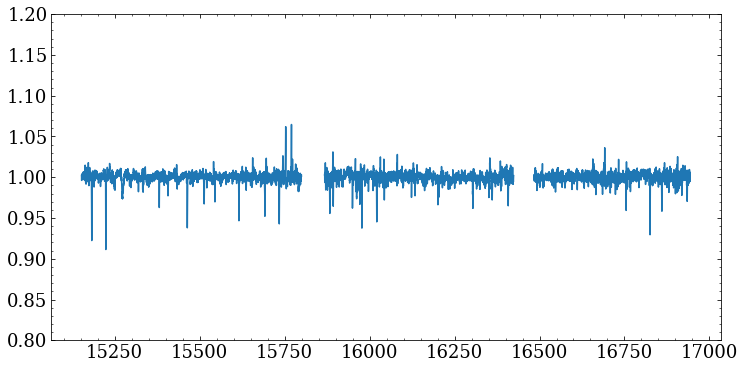

 58%|█████▊    | 11/19 [01:02<00:45,  5.64s/it]

bin (6500, 7000) (3.5, 4.0) (-0.40000000000000124, -0.10000000000000142) stars in bin 16


/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


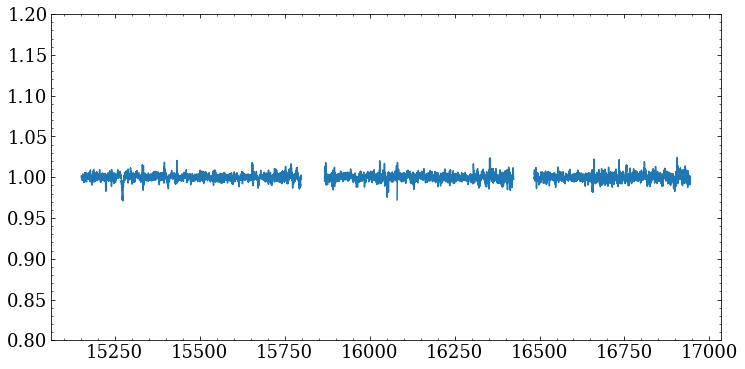

bin (6500, 7000) (3.5, 4.0) (-0.10000000000000142, 0.1999999999999984) stars in bin 10


/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


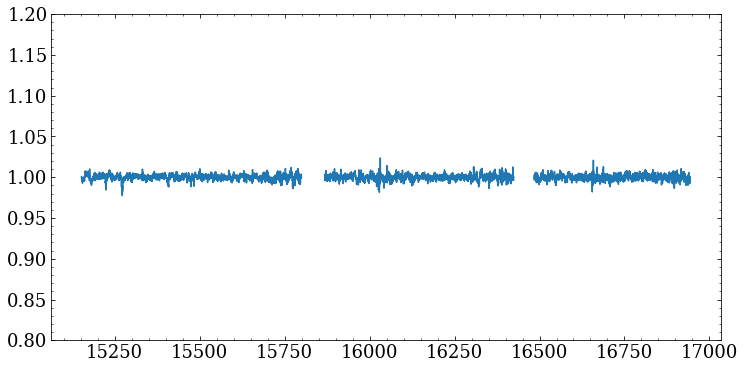

bin (6500, 7000) (4.0, 4.5) (-0.40000000000000124, -0.10000000000000142) stars in bin 12


/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


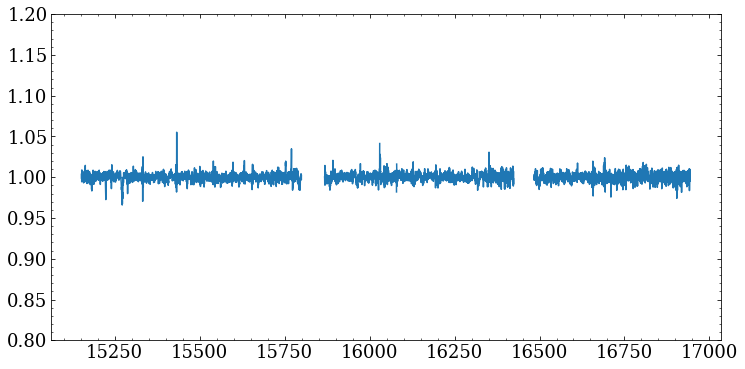

bin (6500, 7000) (4.0, 4.5) (-0.10000000000000142, 0.1999999999999984) stars in bin 13


/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/numpy-1.18.1-py3.6-linux-x86_64.egg/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


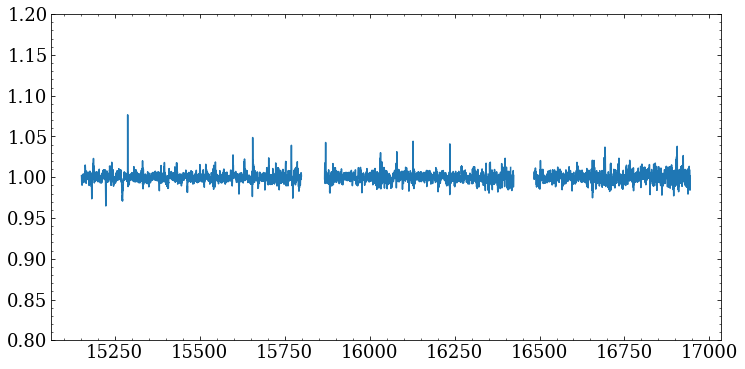

 95%|█████████▍| 18/19 [01:09<00:03,  3.87s/it]


In [12]:
### THIS ONE IS WRONG - DOESN'T MASK

def get_selected_stars(tab, teff_bin, logg_bin, m_h_bin, return_indices = False):
    with np.errstate(divide='ignore', invalid = 'ignore'):
        indices = np.where((tab['TEFF'] > teff_bin[0]) & (tab['TEFF'] < teff_bin[1]) & 
                            (tab['LOGG'] > logg_bin[0]) & (tab['LOGG'] < logg_bin[1]) & 
                            (tab['M_H'] > m_h_bin[0]) & (tab['M_H'] < m_h_bin[1]))[0]
    if return_indices:
        return indices
    else:
        return tab[indices]

for i in tqdm(range(len(teff_bins)-1), total = len(teff_bins)):
    for j in range(len(logg_bins)-1):
        for k in range(len(m_h_bins)-1):
            teff_bin = (teff_bins[i], teff_bins[i+1])
            logg_bin = (logg_bins[j], logg_bins[j+1])
            m_h_bin = (m_h_bins[k], m_h_bins[k+1])
            
            selected_i = get_selected_stars(CA_stars, teff_bin, logg_bin, m_h_bin, return_indices = True)
            select = CA_stars[selected_i]
            
            
            
            stars_names = getspecpaths(select)
    
            nstars = len(stars_names)
            if nstars > 5:
                print('bin', teff_bin, logg_bin, m_h_bin, 'stars in bin', len(stars_names))
                CA_stars['BINNED'][selected_i] = nstars
                
                hdus = tuple(fits.open(name) for name in stars_names)
                headers = tuple(hdu[1].header for hdu in hdus)
                CRVAL1 = headers[0]['CRVAL1']
                CDELT1 = headers[0]['CDELT1']
                
                apStar = tuple(getapstarpath(hdu_) for hdu_ in hdus)
                bitmask = np.array(tuple(fits.open(name)[3].data[0,:] for name in apStar))
                mask = create_mask(bitmask, skipflags = [10,11]).astype(int)
                
                errors = np.array(tuple(hdu[2].data for hdu in hdus))
                
                mask = mask + create_errmask(errors, threshold = 2)
                
#                 mask = np.zeros(mask.shape)
                
                spectra = ma.array(tuple(hdu[1].data for hdu in hdus), mask = mask)
                models = ma.array(tuple(hdu[3].data for hdu in hdus), mask = mask)
#                 errors = ma.array(tuple(hdu[2].data for hdu in hdus), )
            
                
                
                with np.errstate(divide='ignore', invalid = 'ignore'):
                    residuals = spectra / models
                    
                residuals_median, resstd = (np.nanmedian(residuals, axis = 0), np.nanstd(residuals, ddof = 1, axis = 0))
                
                CA_stars['RES_STD'][selected_i] = np.nanmean(resstd)
                
                wavs = np.power(10, CRVAL1 + CDELT1 * np.arange(len(residuals_median)))

                fig = plt.figure(figsize = (12,6))
                ax = plt.subplot()
                ax.plot(wavs, residuals_median)
#                 ax.set_xlim(15250, 15500)
                ax.set_ylim(.8, 1.2)
                plt.show()
            
                header = fits.Header()
                header['NBIN'] = nstars
                header['CRVAL1'] = CRVAL1
                header['CDELT1'] = CDELT1
                header['COMMENT'] = 'BINBORDERS: TEFF ' + str(teff_bin) + ' LOGG ' + str(logg_bin)  + ' M_H ' + str(m_h_bin)
                primaryhdu = fits.PrimaryHDU(header = header)
                residualhdu = fits.ImageHDU(data = residuals_median.data)
                errhdu = fits.ImageHDU(data = resstd.data)
                
                hdul = fits.HDUList([primaryhdu, residualhdu, errhdu])
                fname = 'residual_CA_' + str(i) + '_' + str(j) + '_'+ str(k) + '.fits'
#                 hduout.header = headers[0]
#                 hduout.header.set('BINBORDERS', 'TEFF ' + str(teff_bin) + ' LOGG ' + str(logg_bin) + ' M_H ' + str(m_h_bin))
#                 hdul.writeto('StellarResidualsSpring2022/ResidualsFiles/CACLOUD/' + fname, overwrite = True)
                
                
            
            



In [ ]:

fig, axs = plt.subplots(4,2, figsize = (24,48))



def hr_std_hist(ax, tab, fig = fig, teffbins = teff_bins, loggbins = logg_bins):
    binmin, binmax = (np.min(teffbins), np.max(teffbins))
    binmin_, binmax_ = (np.min(loggbins), np.max(loggbins))
    binsize = np.array([teffbins,loggbins])
    histrange = (teffbins, loggbins)
    hist = np.histogram2d(tab['TEFF'], tab['LOGG'], bins = binsize)[0]
    hist[np.where(hist < 4)] = np.nan
#     norm = colors.LogNorm(vmin = 0.1, vmax = 100)
    
#     image = ax.imshow(hist.T[:, -1:0:-1], cmap = 'PuBu', extent = (binmax,binmin, binmax_,binmin_), vmin = 1, vmax = 20)#, norm = norm)#, vmin = 0, vmax= 50)#, norm = norm)
        
    
    bins1 = np.concatenate([np.arange(3000, 5000, 250), [5000]])
    bins2 = np.concatenate([np.arange(5000,10000, 500), [10000]])
    hist1 = np.histogram2d(tab['TEFF'], tab['LOGG'], bins = (bins1, loggbins))[0]
    hist1[np.where(hist1 < 5)] = np.nan
    norm = colors.LogNorm(vmin = 0.1, vmax = 100)


#     image1 = ax.imshow(hist1.T[:, -1:0:-1], cmap = 'PuBu', extent = (5000,3000, 5,-1), norm = norm)#, vmin = 1, vmax = 20)#, norm = norm)#, vmin = 0, vmax= 50)#, norm = norm)
    image1 = ax.imshow()
    hist2 = np.histogram2d(tab['TEFF'], tab['LOGG'], bins = (bins2, loggbins))[0]
    hist2[np.where(hist2 < 5)] = np.nan
    image2 = ax.imshow(hist2.T[:, -1:0:-1], cmap = 'PuBu', extent = (10000,5000, 5,-1), norm = norm)# vmin = 1, vmax = 20)#, norm = norm)#, vmin = 0, vmax= 50)#, norm = norm)

    
        
    ax.set_aspect((8000 - binmin) / 6)
#     fig.colorbar(image, ax = ax, label = 'Binned Stars',fraction=0.046)
    ax.set_xlim(8000, binmin)
    ax.set_ylim(binmax_, binmin_)
#     ax.set_xticks(np.arange(binmax, binmin, -1000))
    ax.set_xlabel('TEFF')
    ax.set_ylabel('LOGG')

def plot_hr(ax, tab, fig = fig):
    ax.scatter(tab['TEFF'], tab['LOGG'], color = 'r', s= 50, alpha = 0.5)

# fig.subplots_adjust(hspace=0.5)
m_h_bins = np.arange(-2.5, 1.1, .5)
for i in range(4):
    for j in range(2):
        if (i==3) & (j==1):
            break
        stars_restricted = stars[np.where((stars['M_H'] > m_h_bins[2*i+j]) & (stars['M_H'] < m_h_bins[2*i+j+1]))[0]]
#         hr_hist(axs[i, j], stars_restricted)
#         hr_hist_bins(axs[i,j], stars_restricted, teffbins = teffbins, loggbins = loggbins)
        axs[i,j].set_title(str(round(m_h_bins[2*i+j],1))+  ' to ' + str(round(m_h_bins[2*i+j+1],1)))
        
        
        CA_stars_restricted = CA_stars[np.where((CA_stars['M_H'] > m_h_bins[2*i+j]) & (CA_stars['M_H'] < m_h_bins[2*i+j+1]))[0]]
        hr_hist_bins(axs[i,j], CA_stars_restricted)
        plot_hr(axs[i, j], CA_stars_restricted)
# hr_hist(axs[0,0], stars)
# hr_hist(axs[0,1], stars)
# hr_hist(axs[1,0], stars)
# hr_hist(axs[1,1], stars)
plt.show()

In [ ]:
plt.plot(stars['LOGG'])

In [ ]:
CA_stars['RES_STD']

In [ ]:
inds = np.array([np.digitize(CA_stars['TEFF'], bins = teff_bins), np.digitize(CA_stars['LOGG'], bins = logg_bins)])

In [ ]:
inds.shape

In [ ]:
fig = plt.figure()
ax = plt.subplot()
points = ax.scatter(CA_stars['TEFF'], CA_stars['LOGG'], c= CA_stars['RES_STD'])
fig.colorbar(points, ax = ax)
ax.set_xlim(8000, 3000)
ax.set_ylim(5,-1)
plt.show()

In [ ]:
#scipy 

In [ ]:
# PLOTS TO MAKE
# Residuals at set temperature, stepping down in m_h
#  Possibly here also include residual errors as shaded region surrounding
# Other bin stuff? the bins are my big hangup right now asdfdsaf
